<a href="https://colab.research.google.com/github/Ashu156/Social-W-behavioral-analysis/blob/main/docs/module-03-01_Models-of-Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/shawnrhoads/gu-psyc-347/blob/master/docs/module-03-01_Models-of-Learning.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

# Models of Learning

This tutorial was inspired by and adapted from [Wilson & Collins (2019)](https://elifesciences.org/articles/49547). Ten simple rules for the computational modeling of behavioral data. eLife.


## Table of Contents
1. [Model 1: Random Responding](#random-responding)
2. [Model 2: Noisy Win-Stay Lose-Shift](#noisy-win-stay-lose-shift)
3. [Model 3: Rescorla-Wagner](#rescorla-wagner)
4. [Gain a better understanding of learning parameters](#model-parameters)
5. [Fitting an RL model with MLE](#model-fitting)

In [1]:
from scipy.optimize import minimize # finding optimal params in models
from scipy import stats             # statistical tools
import numpy as np                  # matrix/array functions
import pandas as pd                 # loading and manipulating data
import ipywidgets as widgets        # interactive display
import matplotlib.pyplot as plt     # plotting
%matplotlib inline

np.random.seed(2021)                # set seed for reproducibility

## Simulating Learning

Recall the example from our reading [Wilson & Collins (2019)](https://elifesciences.org/articles/49547): participants make a series of $T$ choices between $K$ slot machines (multi-armed bandits) with the goal of maximizing their earnings. If played on trial $t$, each slot machine, $k$, pays out a reward, $r_t$, which is `1` with reward probability, $\mu^k_t$, and otherwise `0`. The reward probabilities are different for each slot machine and are initially unknown to the participant. In the simplest version of the task, the reward probabilities are fixed over time.

We have three experimental parameters for this task:
1. the number of trials, $T$
2. the number of slot machines, $K$
3. the reward probabilities of the different options, $\mu^k_t$, which may or may not change over time

Let's try out the different models proposed in the paper and simulate some behavior based on these models. We will set `T = 100` (100 trials), `K = 2` (two slot machines), and `mu = [.2, .8]` (machine 1 pays out with 20% probability, machine 2 pays out with 80% probability).

In [2]:
T = 100
K = 2
mu = [0.2, 0.8]

## Random Responding

In the first model, participants are assumed to not engage with the task at all. They simply select machines at random with a possible bias for one machine over the other. This bias is captured with a parameter $b$ (which is between 0 and 1) such that the probability of choosing the two options is

$$
p^1_t = b \quad \mbox{and}\quad p^2_t = 1-b
$$

Thus, for two bandits, the random responding model has just one free parameter, controlling the overall bias for option 1 over option 2, $b$.

***Note***: This kind of random behavior is not uncommon in behavioral experiments, especially when participants have no incentives for performing well. Modeling such behavior can be important to identify these "checked-out" participants (either for exclusion or to study the "checked-out" behavior itself).

In [3]:
# Specify the random responding model as a function
def simulate_RandomModel(b, T, mu):
    c = np.zeros((T), dtype = int)
    r = np.zeros((T), dtype = int)

    for t in range(T):

        # compute choice probabilities
        p = [b, 1-b]

        # make choice according to choice probababilities
        c[t] = np.random.choice(range(len(mu)), p=p)

        # generate reward based on choice
        r[t] = np.random.rand() < mu[c[t]]

    return c, r

In [4]:
# simulate the random responding model
c1, r1 = simulate_RandomModel(b=.5, T=T, mu=mu)

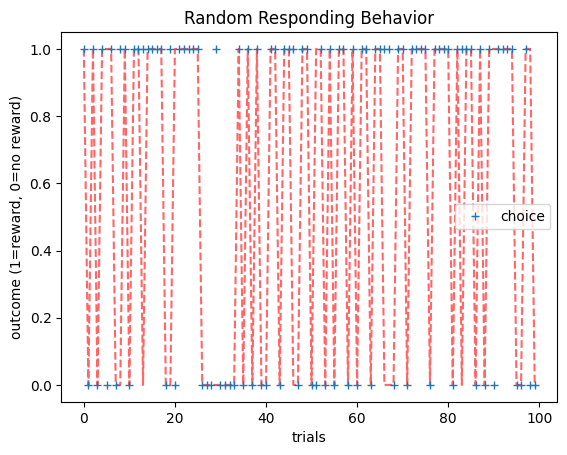

In [5]:
# plot the simulation
plt.plot(range(T), r1, 'r--', alpha=.6)
plt.plot(range(T), c1, '+', label='choice')
plt.xlabel('trials')
plt.ylabel('outcome (1=reward, 0=no reward)')
plt.title(f'Random Responding Behavior')
plt.legend()
plt.show()

As we can see, the behavior here is fairly random.

## Noisy Win-Stay-Lose-Shift

The win-stay-lose-shift model is a simple model that assumes that participants adapt behavior according to feedback on the previous trial. The model repeats rewarded actions and switches away from unrewarded actions. In the noisy version of the model, the win-stay-lose-shift rule is applied probabilistically, such that the model applies the win-stay-lose-shift rule with probability $1-\epsilon$, and chooses randomly with probability $\epsilon$.

In the two-bandit case, the probability of choosing option $k$ (where $k$ represents one of two bandits) is

$$
p^k_t = \left\{
        \begin{array}{cc}
             1- \epsilon / 2
             & \mbox{if } (c_{t-1} = k \mbox{ and } r_{t-1} = 1) \mbox{ OR } (c_{t-1} \ne k \mbox{ and } r_{t-1} = 0)\\
             \epsilon / 2
             & \mbox{if } (c_{t-1} \ne k \mbox{ and } r_{t-1} = 1) \mbox{ OR } (c_{t-1} = k \mbox{ and } r_{t-1} = 0)
        \end{array}
    \right.
$$

where $c_t=1,2$ is the choice at trial $t$, and $r_t=0,1$ the reward at trial $t$. This model also only has one free parameter, the overall level of randomness, $\epsilon$.


In [6]:
def simulate_WSLS(epsilon, T, mu):

    c = np.zeros((T), dtype = int)
    r = np.zeros((T), dtype = int)

    # last reward/action (initialize as nan)
    last_reward = np.nan
    last_choice = np.nan


    for t in range(T):

        # compute choice probabilities
        if np.isnan(last_reward):

            # first trial choose randomly
            p = [0.5, 0.5]

        else:

            # choice depends on last reward
            if last_reward == 1:

                # win stay (with probability 1-epsilon)
                p = [(epsilon/2) * i for i in [1, 1]]
                p[last_choice] = 1 - epsilon/2
            else:

                # lose shift (with probability 1-epsilon)
                p = [(1 - epsilon/2) * i for i in [1, 1]]
                p[last_choice] = epsilon / 2;

        # make choice according to choice probababilities
        c[t] = np.random.choice(range(len(mu)), p=p)

        # generate reward based on choice
        r[t] = np.random.rand() < mu[c[t]]

        last_choice = c[t]
        last_reward = r[t]

    return c, r

In [7]:
c2, r2 = simulate_WSLS(epsilon=.1, T=T, mu=mu)

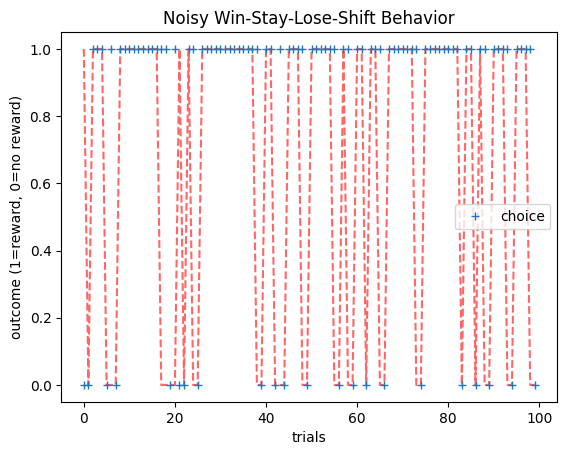

In [8]:
# plot the simulation
plt.plot(range(T), r2, 'r--', alpha=.6)
plt.plot(range(T), c2, '+', label='choice')
plt.xlabel('trials')
plt.ylabel('outcome (1=reward, 0=no reward)')
plt.title(f'Noisy Win-Stay-Lose-Shift Behavior')
plt.legend()
plt.show()

Here, we can see that behavior switches (with noise) whenever there is no reward on the previous trial.

## Taking the Average?

As discussed previously in class, another very simple thing we could do is to compute the average reward (then choose probabilistically according to the updated value of the machines). This model can be expressed as:

$$
V(t) = \frac{1}{T} \sum_{i=1}^{T} r_i
$$

However, we crucially learned that there's a big conceptual problem with the model as it's currently written. Even if humans or animals are computing the mean of the rewards it is unlikely they are doing it using this equation. Even with `T=50` trials, how easy do you think it would be to compute a sum like that directly? How about when `T=100`?

The problem is that we would have to keep track of all the rewards we've seen so far to compute it. For example, when `T=100` we have to keep track of 100 rewards. If `T=10000`, then we need to keep track of a 10,000 rewards! This doesn't seem plausible. No one can remember a random string of a ten-thousand 0s and 1s (the world record for [remembering binary digits in 30 minutes is 7,485](https://www.guinnessworldrecords.com/world-records/360573-most-binary-digits-memorised-in-30-minutes#:~:text=The%20most%20binary%20digits%20memorized,4%20to%208%20December%202019.)).

Maybe we can "take the average" in a different kind of way that doesn't involve keeping track of so many outcomes!

## Rescorla-Wagner

Enter **Rescorla-Wagner**. As discussed in class, Rescorla and Wagner (in one of great papers of the 20th Century) proposed that learning occurs when there is a prediction error. In their model, participants first learn the expected value of each slot machine based on the history of previous outcomes and then use these values to make a decision about what to do next. A simple model of learning is the Rescorla-Wagner learning rule (Rescorla & Wagner, 1972) whereby the value of option $k$, $Q^k_t$ is updated in response to reward $r_t$ according to:

$$
Q^k_{t+1} = Q^k_t + \alpha (r_t - Q^k_t)
$$

where $\alpha$ is the learning rate, which is bounded between 0 and 1 and captures the extent to which the prediction error, $(r_t - Q^k_t)$, updates the value (i.e., a higher $\alpha$ value will put greater weight on the prediction error). For simplicity, we assume that the initial value, $Q^k_0=0$, although it is possible to treat the $Q^k_0$ as a free parameter of the model (this is also the intercept).

A simple model of decision making is to assume that participants use the options' values to guide their decisions, choosing the most valuable option most frequently, but occasionally making 'mistakes' (or exploring) by choosing a low value option. One choice rule with these properties is known as the **'softmax' choice rule**, which chooses option $k$ with probability:

$$
p^k_t = \frac{\exp(\theta Q^k_t)}{\sum_{i=1}^K \exp(\theta Q^i_t)}
$$

where $\theta$ is the 'inverse temperature' parameter that controls the level of stochasticity in the choice, ranging from $\theta = 0$ for completely random responding and $\theta = \infty$ for deterministically choosing the highest value option. In other words, someone with a large $\theta$ would almost always choose the option with the highest value ($Q^k_t$), while someone with a small $\theta$ would explore other options more frequently.

Combining the learning and decision rules gives a simple model of decision making in this task with two free parameters: the learning rate, $\alpha$, and the inverse temperature $\theta$.

In [9]:
def simulate_RescorlaWagner(params, T, mu, noisy_choice=True):

    alpha, theta = params

    c = np.zeros((T), dtype = int)
    r = np.zeros((T), dtype = int)

    Q_stored = np.zeros((2, T), dtype = float)
    Q = [0.5, 0.5]

    for t in range(T):

        # store values for Q_{t+1}
        Q_stored[:,t] = Q

        # compute choice probabilities
        p0 = np.exp(theta*Q[0]) / (np.exp(theta*Q[0]) + np.exp(theta*Q[1]))
        p1 = 1 - p0

        # make choice according to choice probababilities
        # as weighted coin flip to make a choice
        # choose stim 0 if random number is in the [0 p0] interval
        # and 1 otherwise
        if noisy_choice:
            if np.random.random_sample(1) < p0:
                c[t] = 0
            else:
                c[t] = 1
        else: # make choice without noise
            c[t] = np.argmax([p0,p1])

        # generate reward based on reward probability
        r[t] = np.random.rand() < mu[c[t]]

        # update values
        delta = r[t] - Q[c[t]]
        Q[c[t]] = Q[c[t]] + alpha * delta

    return c, r, Q_stored

In [10]:
c3, r3, Q = simulate_RescorlaWagner([.1, 1.5], T=T, mu=mu)

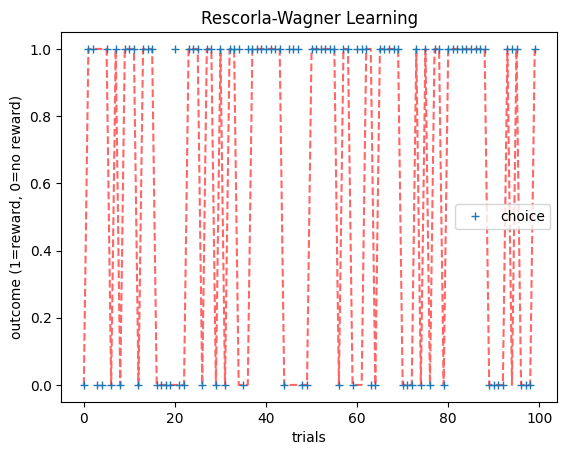

In [11]:
# plot the simulation
plt.plot(range(T), r3, 'r--', alpha=.6)
plt.plot(range(T), c3, '+', label='choice')
plt.xlabel('trials')
plt.ylabel('outcome (1=reward, 0=no reward)')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()

As we can observe, choices for the machine that yields less rewards become less frequent over trials.

We can also plot the values of the machines over trials. Let's see what that looks like.

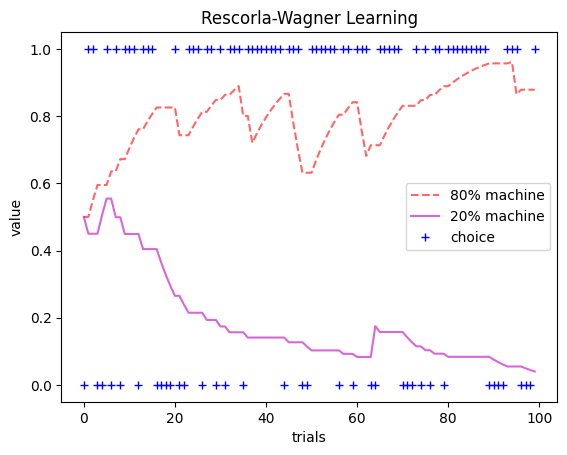

In [12]:
# plot the simulation
plt.plot(range(T), Q[1,:], 'r--', alpha=.6, label='80% machine')
plt.plot(range(T), Q[0,:], 'm-', alpha=.6, label='20% machine')
plt.plot(range(T), c3, 'b+', label='choice')
plt.xlabel('trials')
plt.ylabel('value')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()

It's pretty cool that the value of the machines over trials slowly converges towards their reward outcomes probabilities (20% and 80%)!

<hr>

## Model Parameters

Before moving on, let's get a better intuition for how learning changes for different values of the probability of the first machine, $\alpha$, and $\theta$

<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.css" integrity="sha512-5A8nwdMOWrSz20fDsjczgUidUBR8liPYU+WymTZP1lmY9G6Oc7HlZv156XqnsgNUzTyMefFTcsFH/tnJE/+xBg==" crossorigin="anonymous" />

> Add blockquote



<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js"></script>

<script type="text/x-thebe-config">
     {
       requestKernel: true,
       binderOptions: {
         repo: "matplotlib/ipympl",
         ref: "0.6.1",
         repoProvider: "github",
       },
     }
</script>
<script src="https://unpkg.com/thebe@latest/lib/index.js"></script>
   
<button id="activateButton" style="width: 450px; height: 40px; font-size: 1.5em;">
     Click here to interact with this visualization
</button>

<script>
var bootstrapThebe = function() {
   thebelab.bootstrap();
}
document.querySelector("#activateButton").addEventListener('click', bootstrapThebe)
</script>

<pre data-executable="true" data-language="python">
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np

def simulate_RescorlaWagner(params, T, mu, noisy_choice=True):
    alpha, theta = params
    c = np.zeros((T), dtype = int)
    r = np.zeros((T), dtype = int)

    Q_stored = np.zeros((2, T), dtype = float)
    Q = [0.5, 0.5]

    for t in range(T):

        # store values for Q_{t+1}
        Q_stored[:,t] = Q
        
        # compute choice probabilities
        p0 = np.exp(theta*Q[0]) / (np.exp(theta*Q[0]) + np.exp(theta*Q[1]))
        p1 = 1 - p0
        
        # make choice according to choice probababilities
        # as weighted coin flip to make a choice
        # choose stim 0 if random number is in the [0 p0] interval
        # and 1 otherwise
        if noisy_choice:
            if np.random.random_sample(1) < p0:
                c[t] = 0
            else:
                c[t] = 1
        else: # make choice without noise
            c[t] = np.argmax([p0,p1])
        
        # generate reward based on reward probability
        r[t] = np.random.rand() < mu[c[t]]

        # update values
        delta = r[t] - Q[c[t]]
        Q[c[t]] = Q[c[t]] + alpha * delta

    return c, r, Q_stored

def plot_values(beta_hat, theta_hat, T, mu):
    c, r, Q = simulate_RescorlaWagner([beta_hat, theta_hat], T, mu)
    
    plt.plot(range(T), Q[1,:], 'r--', alpha=.6, label=f'{mu[1]*100:.0f}% machine')
    plt.plot(range(T), Q[0,:], 'm-', alpha=.6, label=f'{mu[0]*100:.0f}% machine')
    plt.plot(range(T), c, 'b+', label='choice')
    plt.xlabel('trials')
    plt.ylabel('value')
    plt.title(f'Rescorla-Wagner Learning')
    plt.legend()
    plt.show()

# interactive display
%config InlineBackend.figure_format = 'retina'

@widgets.interact(trials=widgets.IntSlider(200, min=20, max=200),
                  probability=widgets.FloatSlider(.8, min=0, max=1),
                  alpha_hat=widgets.FloatSlider(.1, min=0, max=1),
                  theta_hat=widgets.FloatSlider(1.5, min=0, max=10))

def plot_interactive(trials, probability, alpha_hat, theta_hat):
    plot_values(alpha_hat, theta_hat, int(trials), [1-probability, probability])
</pre>

In [13]:
def plot_values(beta_hat, theta_hat, T, mu):
    c, r, Q = simulate_RescorlaWagner([beta_hat, theta_hat], T, mu)

    plt.plot(range(T), Q[1,:], 'r--', alpha=.6, label=f'{mu[1]*100:.0f}% machine')
    plt.plot(range(T), Q[0,:], 'm-', alpha=.6, label=f'{mu[0]*100:.0f}% machine')
    plt.plot(range(T), c, 'b+', label='choice')
    plt.xlabel('trials')
    plt.ylabel('value')
    plt.title(f'Rescorla-Wagner Learning')
    plt.legend()
    plt.show()

# interactive display
%config InlineBackend.figure_format = 'retina'

@widgets.interact(trials=widgets.IntSlider(200, min=20, max=200),
                  probability=widgets.FloatSlider(.8, min=0, max=1),
                  alpha_hat=widgets.FloatSlider(.1, min=0, max=1),
                  theta_hat=widgets.FloatSlider(1.5, min=0, max=10))

def plot_interactive(trials, probability, alpha_hat, theta_hat):
    plot_values(alpha_hat, theta_hat, int(trials), [1-probability, probability])

interactive(children=(IntSlider(value=200, description='trials', max=200, min=20), FloatSlider(value=0.8, desc…

<hr>

## Model fitting

A key component of computational modeling is estimating the values of the parameters that best describe your behavioral data. While there are a number of different ways of estimating parameters, we will focus on the **Maximum-Likelihood** approach. Mathematical details can be found in [Module 02](https://shawnrhoads.github.io/gu-psyc-347/module-02-02_Modeling-Exercises.html#maximum-likelihood-estimation) or in the Appendix of [Wilson & Collins (2019)](https://elifesciences.org/articles/49547).

In the maximum likelihood approach to model fitting, our goal is to find the parameter values of a model $m$ that maximize the **likelihood of the data** $d_{1:T}$. For example, in the Rescorla-Wagner case, we want to maximize the likelihood of the data $d_{1:T}$ given parameter values $(\alpha, \theta)_m$ of the model $m$.

### Computing the negative log likelihood

Maximizing the likelihood is equivalent to maximizing the log of the likelihood, $\log \mathcal{L} = \log p( d_{1:t-1} | (\alpha, \theta)_m, m)$, which is numerically more tractable. A simple mathematical derivation shows that this log likelihood can be written in terms of the choice probabilities of the individual model as

$$
\log \mathcal{L} = \log p(d_{1:T} | (\alpha, \theta)_m, m) = \sum_{t=1}^T \log p(c_t | d_{1:t-1}, s_t, (\alpha, \theta)_m, m)
$$

where $p(c_t | d_{1:t-1}, s_t, (\alpha, \theta)_m, m)$ is the **probability of each individual choice** given the parameters of the model and available information up to that choice.

***Recall that maximizing the log likelihood is the same as minimizing the negative log likelihood!*** Thus, we can rewrite the equation above as:

$$
negative \log \mathcal{L} = -\sum_{t=1}^T \log p(c_t | d_{1:t-1}, s_t, (\alpha, \theta)_m, m)
$$

In practice, the likelihood is simply a function of the data and parameters that we can define for each of the models under consideration. In this notebook, we will focus on the Rescorla Wagner model. For this model, we can write a negative log likelihood function as:

In [14]:
def negll_RescorlaWagner(params, c, r):
    alpha, theta = params

    Q = [0.5, 0.5]
    T = len(c)
    choiceProb = np.zeros((T), dtype = float)

    for t in range(T):

        # compute choice probabilities for k=2
        p0 = np.exp(theta*Q[0]) / (np.exp(theta*Q[0]) + np.exp(theta*Q[1]))
        p = [p0, 1-p0]

        # compute choice probability for actual choice
        choiceProb[t] = p[c[t]]

        # update values
        delta = r[t] - Q[c[t]]
        Q[c[t]] = Q[c[t]] + alpha * delta

    negLL = -np.sum(np.log(choiceProb))

    return negLL

In [15]:
# simulate choices from RW Model
alpha = .1
theta = 1.5
c4, r4, Q2 = simulate_RescorlaWagner([alpha, theta], T=T, mu=[.2,.8])

# evaluate negative log-likelihood for
# this simulated dataset at some other parameter values
alpha_hat = 0.2
theta_hat = 1.5
negLL = negll_RescorlaWagner([alpha_hat, theta_hat], c4, r4)
print(alpha_hat,theta_hat,negLL)

0.2 1.5 70.69609372507034


#### Brute Force

In principle, finding the maximum likelihood parameters is as 'simple' as maximizing the log likelihood. In practice, finding the maximum of a function is not a trivial process. As discussed in Module 02, the simplest approach would be a brute force search of the entire parameter space. Let's try that for our simulated data set. For simplicity, let's assume that we know $\theta$ but don't know $\alpha$.

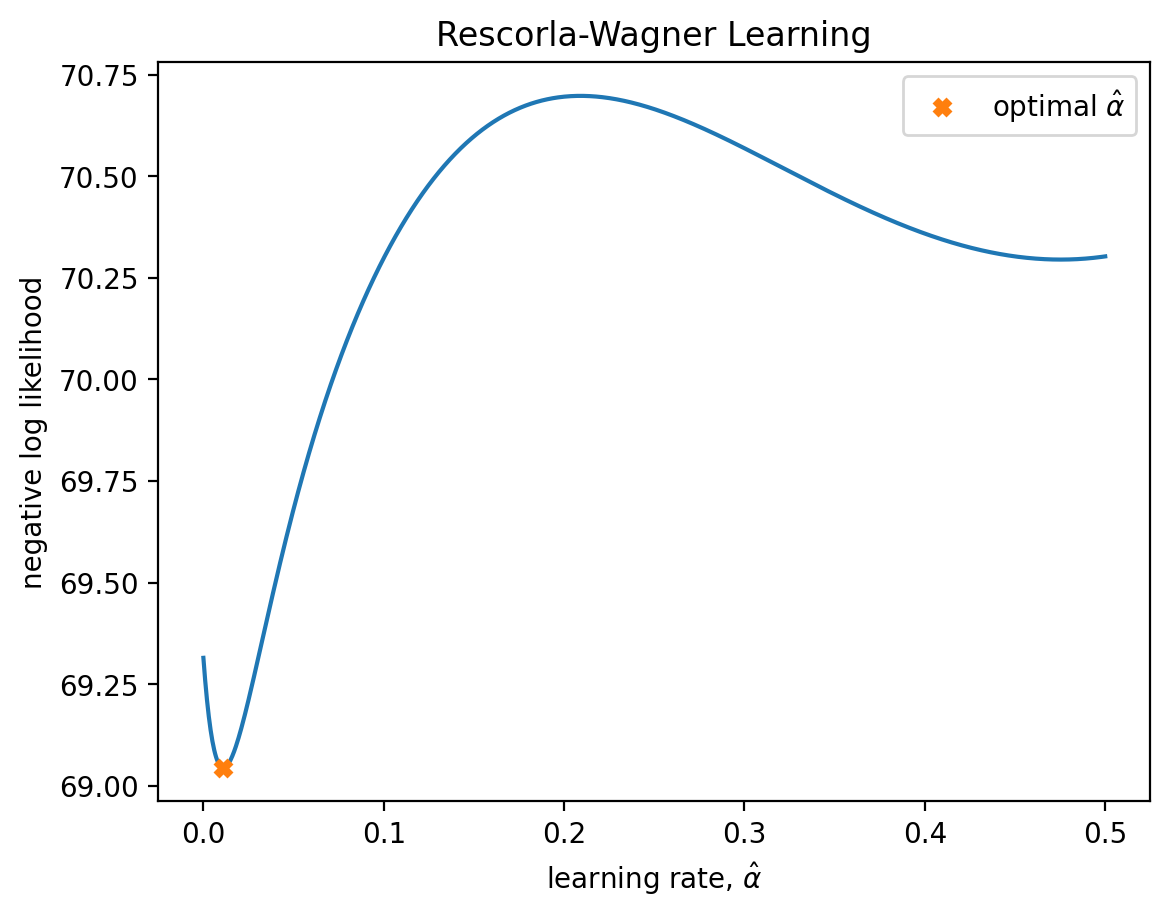

In [16]:
nLL = []
alpha_vals = np.linspace(0,0.5,1000)
for alpha_val in alpha_vals:
    nLL.append(negll_RescorlaWagner([alpha_val, theta], c4, r4))

plt.plot(alpha_vals, nLL, '-')
plt.plot(alpha_vals[np.argmin(nLL)], nLL[np.argmin(nLL)], 'X', label=r'optimal $\hat \alpha$')
plt.ylabel('negative log likelihood')
plt.xlabel(fr'learning rate, $\hat \alpha$')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()

By plotting, the relationship between negative log likelihood and $\hat \alpha$, we can see that optimal $\hat \alpha$ is at the lowest negative log likelihood.

#### Gradient Descent

As we know from Module 2, the brute force approach is unfeasible outside of the simplest cases (e.g. one or two parameters with tight bounds) due to the high computational costs of evaluating the likelihood function at a large number of points.

Fortunately, a number of tools exist for finding local maxima (and minima) of functions quickly using variations on gradient ascent (or descent), such as `scipy.optimize.minimize`!

Let's try it out!

In [17]:
# gradient descent to minimize neg LL
res_nll = np.inf # set initial neg LL to be inf

# guess several different starting points for alpha
for alpha_guess in np.linspace(0,1,10):
    for theta_guess in np.linspace(1,25,10):

        # guesses for alpha, theta will change on each loop
        init_guess = (alpha_guess, theta_guess)

        # minimize neg LL
        result = minimize(negll_RescorlaWagner,
                          init_guess,
                          (c4, r4),
                          bounds=((0,1),(1,50)))

        # if current negLL is smaller than the last negLL,
        # then store current data
        if result.fun < res_nll:
            res_nll = result.fun
            param_fits = result.x

# also, compute BIC
# note: we don't need the -1 because
# we already have the negative log likelihood!
BIC = len(init_guess) * np.log(len(c4)) + 2*res_nll

print(fr'alpha_hat = {param_fits[0]:.2f}, theta_hat = {param_fits[1]:.2f}')
print(fr'BIC = {BIC:.2f}')

alpha_hat = 0.60, theta_hat = 1.00
BIC = 145.85


### Parameter Recovery

It is important to check whether the fitting procedure gives meaningful parameter values in the best case scenario (i.e., when fitting fake data where the 'true' parameter values are known). Such a procedure is known as **parameter recovery** and is a crucial part of any model-based analysis.  

The recipe for parameter recovery is quite simple
1. Simulate fake data with known parameter values
2. Fit the model to this fake data to try to 'recover' the parameters
3. Compare the recovered parameters to their true values

In a perfect world, the simulated and recovered parameters will be tightly correlated without bias. If there is only a weak correlation between simulated and recovered parameters and/or a significant bias, then this is an indication that there is either a bug in your code (often the case) or the experiment is underpowered to assess this model (also often the case!).

Let's simulate data for 50 'fake' participants.

In [18]:
# simulate subjects' alpha and theta params
alpha_sim = stats.truncnorm.rvs((.1),
                                (1-.25),
                                loc=.25,
                                scale=1,
                                size=(50))
theta_sim = stats.truncnorm.rvs((0-.25),
                                (10-.25),
                                loc=1.25,
                                scale=1,
                                size=(50))

# initialize lists to store params and data
negll_sim = []
Q_fit = []
alpha_fit = []
theta_fit = []

# loop over subjects
for subj in range(50):
    np.random.seed(subj)

    alpha = alpha_sim[subj]
    theta = theta_sim[subj]

    # simulate subject data based on alpha, theta
    c_sim, r_sim, Q_sim = simulate_RescorlaWagner([alpha, theta], T, mu);

    # gradient descent to minimize neg LL
    res_nll = np.inf

    # guess several different starting points for alpha
    for alpha_guess in np.linspace(0,1,10):

        # guesses for alpha will change
        # guesses for theta will be constant
        init_guess = (alpha_guess, 1.5)

        # minimize neg LL
        result = minimize(negll_RescorlaWagner,
                          init_guess,
                          (c_sim, r_sim),
                          bounds=((0,1),(1,20)))

        # if current negLL is smaller than the last negLL,
        # then store current data
        if result.fun < res_nll:
            res_nll = result.fun
            param_fits = result.x
            Q_vals = Q_sim

    # append model fits to lists
    negll_sim.append(res_nll)
    Q_fit.append(Q_vals)
    alpha_fit.append(param_fits[0])
    theta_fit.append(param_fits[1])


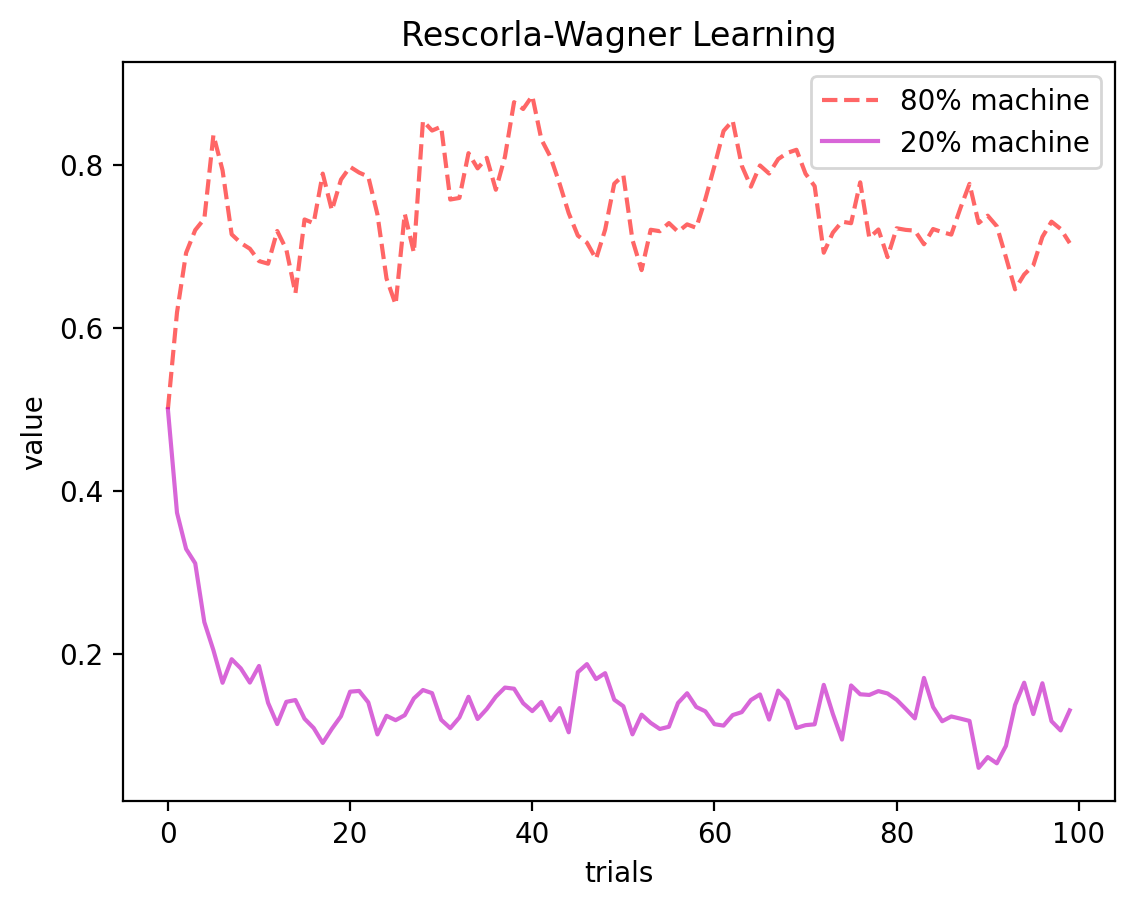

In [19]:
# plot average stimulus values over trials
Q_means = np.mean(np.array(Q_fit), axis=0) # mean over subjects

plt.plot(range(T), Q_means[1,:], 'r--', alpha=.6, label='80% machine')
plt.plot(range(T), Q_means[0,:], 'm-', alpha=.6, label='20% machine')
plt.xlabel('trials')
plt.ylabel('value')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()

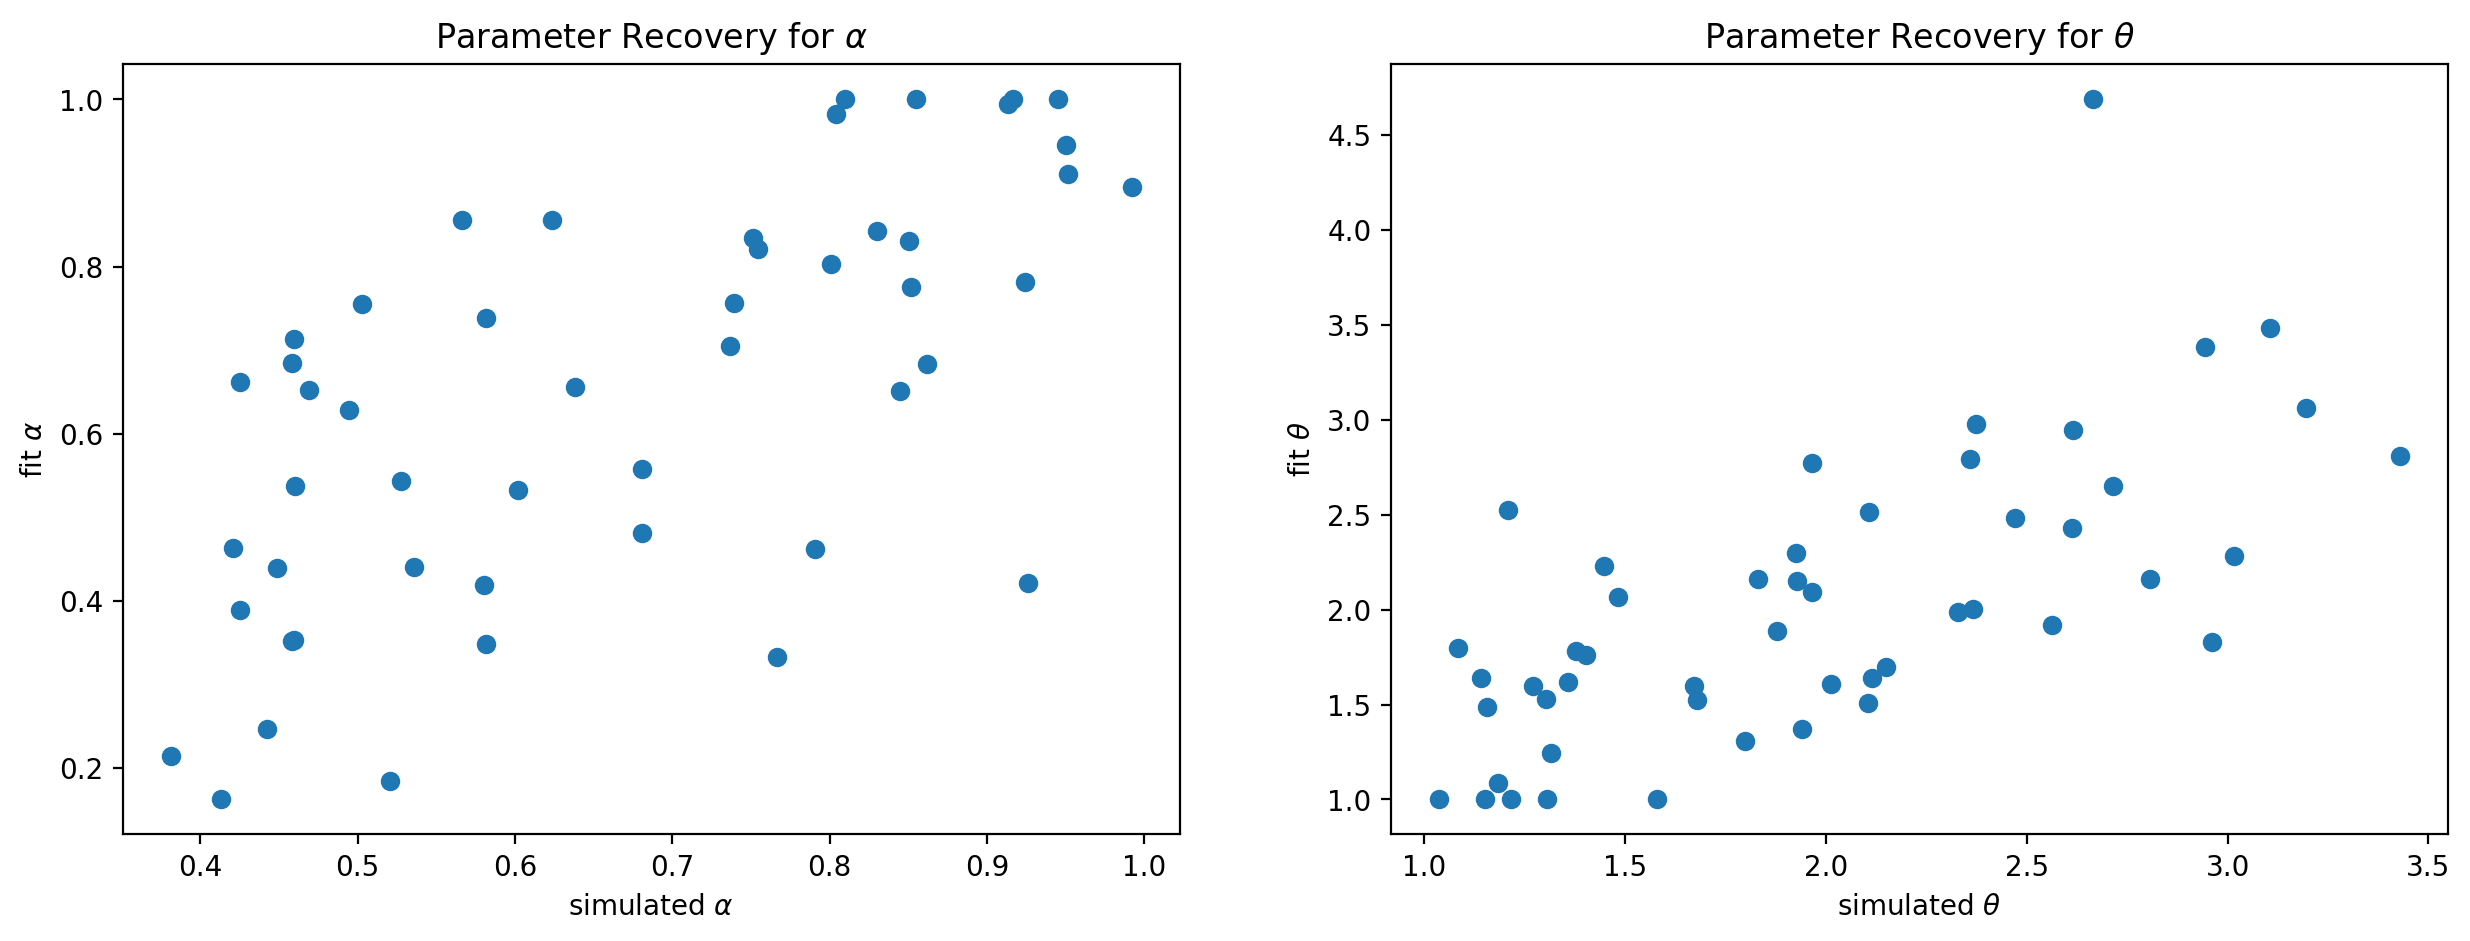

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

# parameter recovery for alpha
axes[0].plot(alpha_sim, alpha_fit, 'o')
axes[0].set(ylabel=r'fit $\alpha$',
            xlabel=r'simulated $\alpha$',
            title=fr'Parameter Recovery for $\alpha$')

axes[1].plot(theta_sim, theta_fit, 'o')
axes[1].set(ylabel=r'fit $\theta$',
            xlabel=r'simulated $\theta$',
            title=fr'Parameter Recovery for $\theta$')
plt.show()